_Version log: Trying the curvature and chord length method._

In [1]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def curvature(x, y):
    # Calculate curvature for each point (x, y)
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(ddx * dy - dx * ddy) / (dx**2 + dy**2)**1.5
    return curvature

def chord_length(x, y):
    deltax = np.diff(x)
    deltay = np.diff(y)
    s = np.hypot(deltax, deltay)
    s = np.abs(s)
    return s

In [3]:
file_number = 12
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"
target, uncertainties = cs.open_dataset("1dmockanderrors{:d}".format(file_number), ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [4]:
reduced_points = 8
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

0.0009970664978027344


C:\Users\syf83691\AppData\Local\Temp\ipykernel_23480\1178371415.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


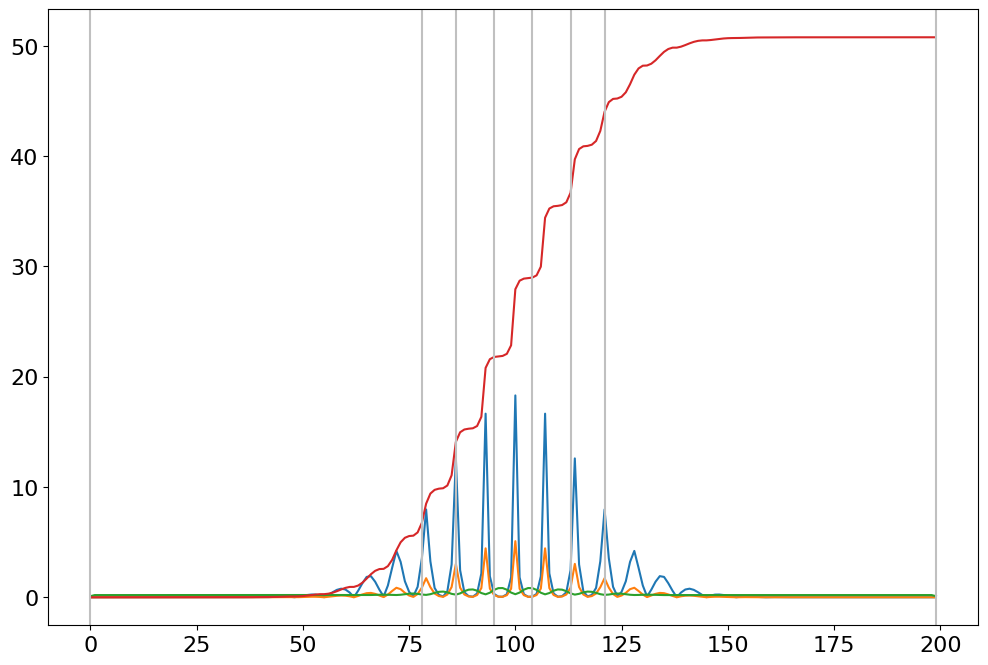

In [5]:
rescaling_factor = 0.1

start_time = time.time()

idx = np.arange(len(target))
k = curvature(rescaling_factor *idx, target)
s = chord_length(rescaling_factor *idx, target)

s_convol = np.convolve(s, [1,1], mode= "full") # add up the value with its neighbor. (s[n] + s[n+1])
ks = k *s_convol
ks_cumsum = np.cumsum(ks)
K = np.sum(ks)
Kn = np.linspace(0, K, reduced_points)

interpolate = spinter.interp1d(ks_cumsum, idx, kind= "nearest", bounds_error= False, fill_value= "extrapolate")
detectors = interpolate(Kn).astype(int)

end_time = time.time()
print(end_time -start_time)

fig, axs = plt.subplots(1,1, figsize= (12, 8))

axs.plot(idx, k)
axs.plot(idx, ks)
axs.plot(idx, s_convol)
axs.plot(idx, ks_cumsum)
axs.vlines(idx[detectors], 0, 1, color= "silver", transform= axs.get_xaxis_transform())
fig.show()

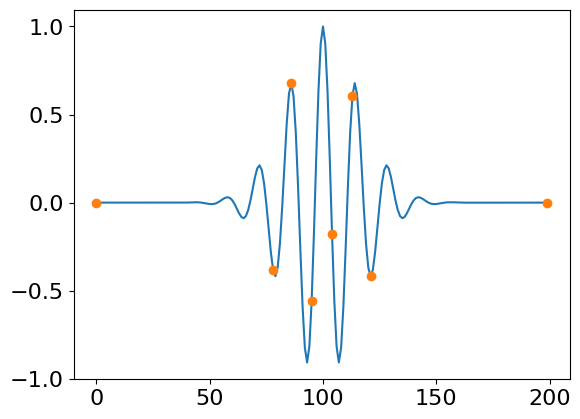

In [6]:
plt.plot(idx, target)
plt.plot(idx[detectors], target[detectors], marker= "o", linestyle= "none")
plt.show()

In [7]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)
score = cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient)

cs.append_array_to_csv(detectors, optlocs_file)
print(score)

3.242102553494784


In [8]:
print(*detectors, sep= ",")

0,78,86,95,104,113,121,199
